# Conservative vertical remapping of WOA 2013

In [1]:
import xarray as xr
from vcr import utils, conserve
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

Load the WOA13 dataset:

In [3]:
woa13dir = '/local2/home/WOA13-prepare'
woa13 = xr.open_dataset(f'{woa13dir}/woa13_decav_t13_01.nc', decode_times=False)

Load the model grid:

In [4]:
ppdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle2/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z_1x1deg/av/annual_5yr/'
model = xr.open_dataset(f'{ppdir}/ocean_annual_z_1x1deg.1968-1972.ann.nc')

Read/Create 1d vector of layer interfaces:

In [5]:
depth_bnds_tgt = model['z_i'].values

In [6]:
depth_bnds_src = utils.bounds_2d_to_1d(woa13['depth_bnds'])

Create the remapping matrix:

In [7]:
remapping = conserve.create_remapping_matrix(depth_bnds_src, depth_bnds_tgt, strict=False)

the strict = False option add a residual to the last source level so that the sum of weights along the source direction adds up to one (or to zero if no source layer exist for target layer)

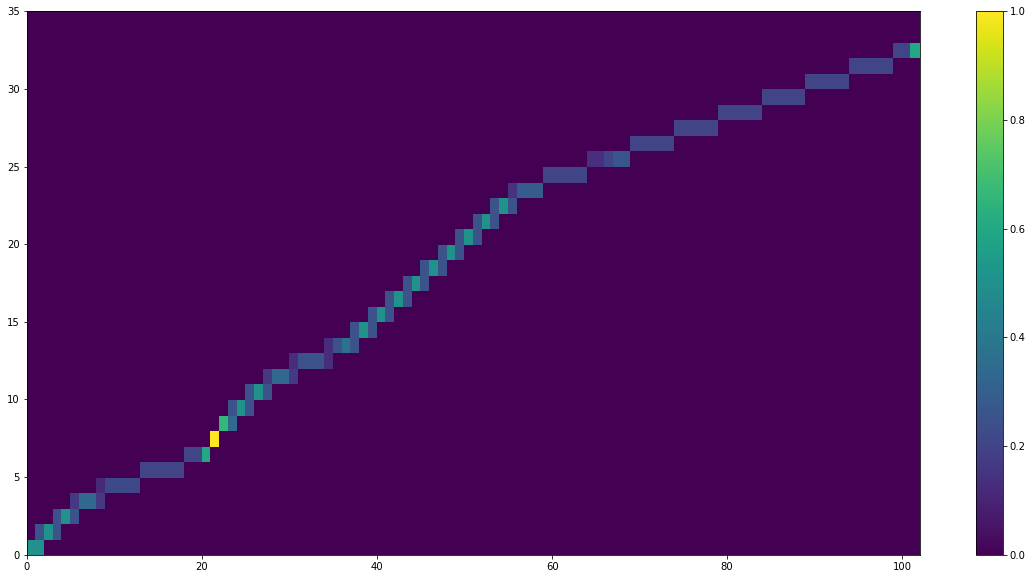

In [8]:
plt.figure(figsize=[20,10])
plt.pcolormesh(remapping)
plt.colorbar()

In [9]:
remapping_strict = conserve.create_remapping_matrix(depth_bnds_src, depth_bnds_tgt, strict=True)

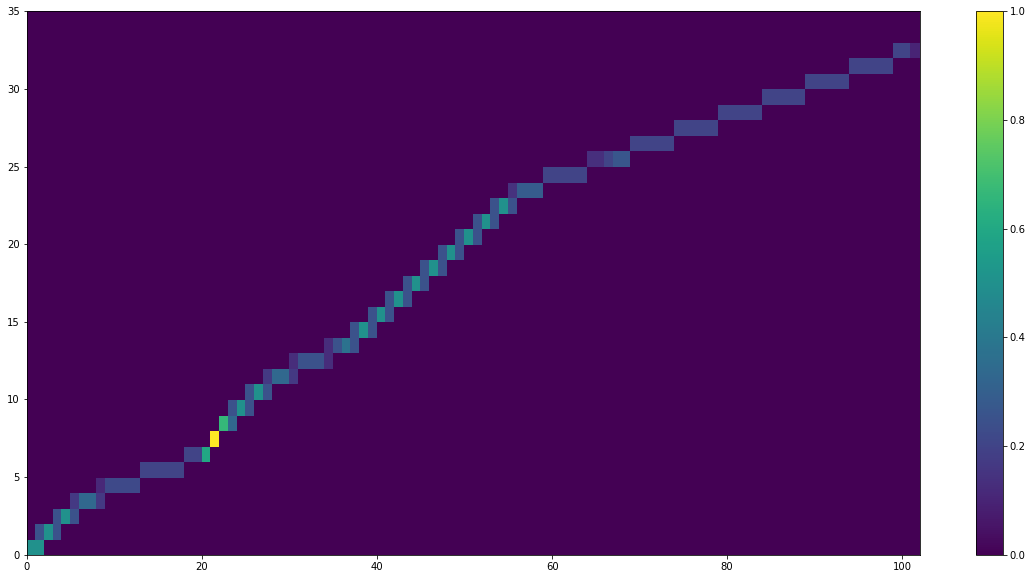

In [10]:
plt.figure(figsize=[20,10])
plt.pcolormesh(remapping_strict)
plt.colorbar()

Remap the data:

In [11]:
temp_remapped = conserve.vertical_remap_z2z(woa13['t_an'].squeeze(dim='time').values, remapping)

In [12]:
temp_remapped_strict = conserve.vertical_remap_z2z(woa13['t_an'].squeeze(dim='time').values, remapping_strict)

Create a nicely formatted xarray.Dataset:

In [13]:
woa13_remapped = xr.Dataset()
woa13_remapped['t_an'] = xr.DataArray(data=temp_remapped, dims=('z_l', 'yh', 'xh'))
woa13_remapped['z_l'] = model['z_l']

woa13_remapped_strict = xr.Dataset()
woa13_remapped_strict['t_an'] = xr.DataArray(data=temp_remapped_strict, dims=('z_l', 'yh', 'xh'))
woa13_remapped_strict['z_l'] = model['z_l']

Let's look at the results quickly:

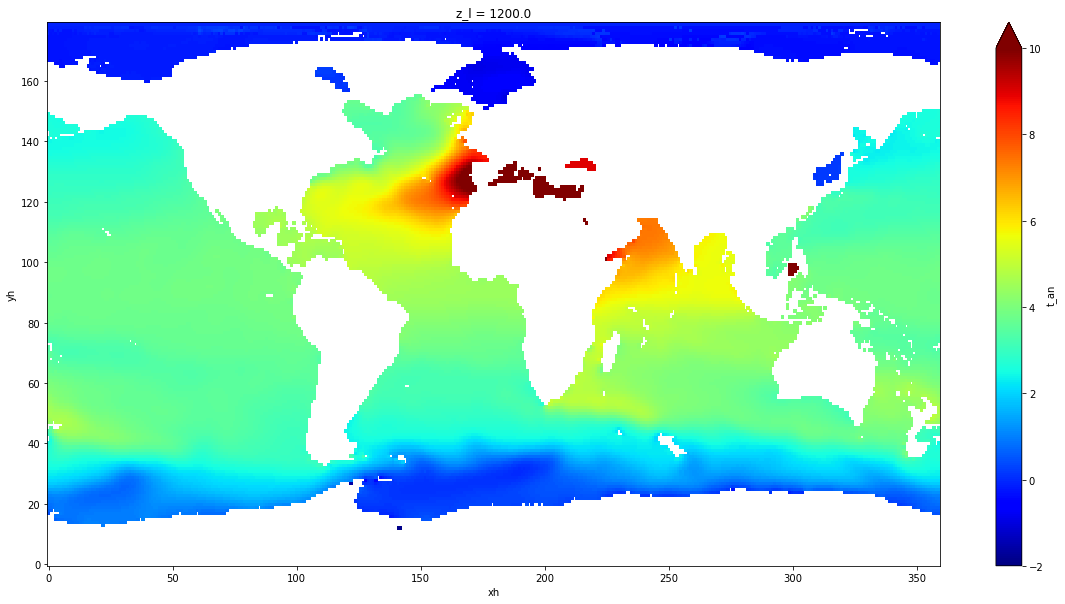

In [14]:
woa13_remapped['t_an'].isel(z_l=20).plot(vmin=-2, vmax=10, cmap='jet', figsize=[20,10])

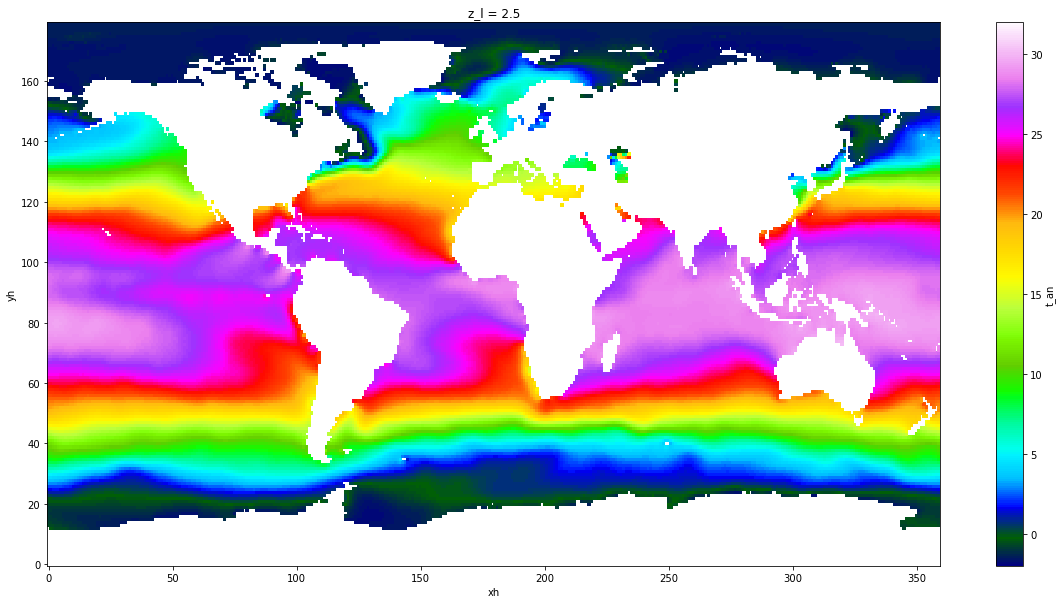

In [15]:
woa13_remapped['t_an'].isel(z_l=0).plot(vmin=-2, vmax=32, cmap='gist_ncar', figsize=[20,10])

It passes the eye-ball test but now let's compare to the original data:

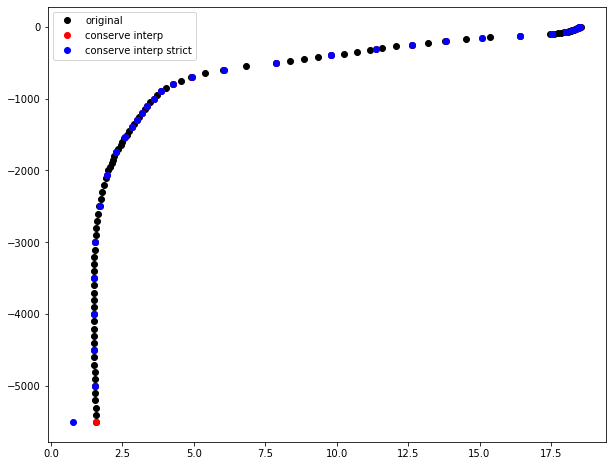

In [16]:
test_datain = woa13['t_an'].isel(time=0,lon=20,lat=120)
test_dataout = woa13_remapped['t_an'].isel(xh=20,yh=120)
test_dataout_strict = woa13_remapped_strict['t_an'].isel(xh=20,yh=120)

plt.figure(figsize=[10,8])
plt.plot(test_datain, -woa13['depth'], 'ko', label='original')
plt.plot(test_dataout, -woa13_remapped['z_l'], 'ro', label='conserve interp')
plt.plot(test_dataout_strict, -woa13_remapped_strict['z_l'], 'bo', label='conserve interp strict')
plt.legend()
plt.show()

Strict and non-strict are exactly the same except for the last point. In non-strict, total is not conserved but value fits better.

Example of a single point in the Gulf of Mexico: Only one depth level here in input, we want the output to match.

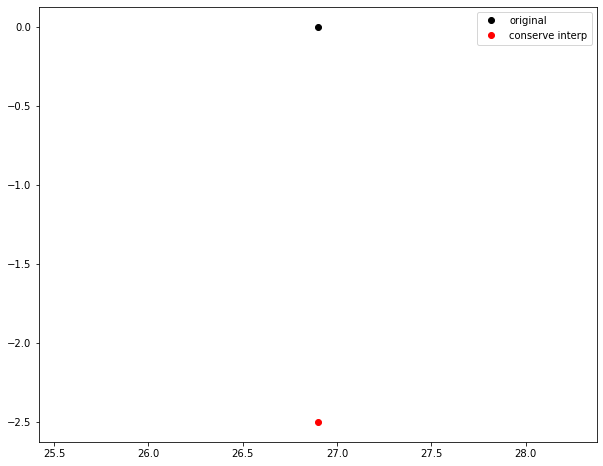

In [17]:
test_datain_single = woa13['t_an'].isel(time=0,lon=97,lat=105)
test_dataout_single = woa13_remapped['t_an'].isel(xh=97,yh=105)

plt.figure(figsize=[10,8])
plt.plot(test_datain_single, -woa13['depth'], 'ko', label='original')
plt.plot(test_dataout_single, -woa13_remapped['z_l'], 'ro', label='conserve interp')
plt.legend()
plt.show()

Note that the deepest point is off. This is due in discrepancies in depth of the bottom cells.
This value should not be used for maps (especially differences). Note that integrating along the water column
gives the correct answer:

In [18]:
layer_thickness_src = depth_bnds_src[1:] - depth_bnds_src[:-1]
layer_thickness_src = layer_thickness_src.astype('float64')
layer_thickness_tgt = depth_bnds_tgt[1:] - depth_bnds_tgt[:-1]

vertsum_in = (test_datain * layer_thickness_src).sum().values
vertsum_out = (test_dataout * layer_thickness_tgt).sum().values
vertsum_out_strict = (test_dataout_strict * layer_thickness_tgt).sum().values

assert np.equal(vertsum_in, vertsum_out_strict)
assert not np.equal(vertsum_in, vertsum_out)

Another way to look at it is by using the cumulative sum:

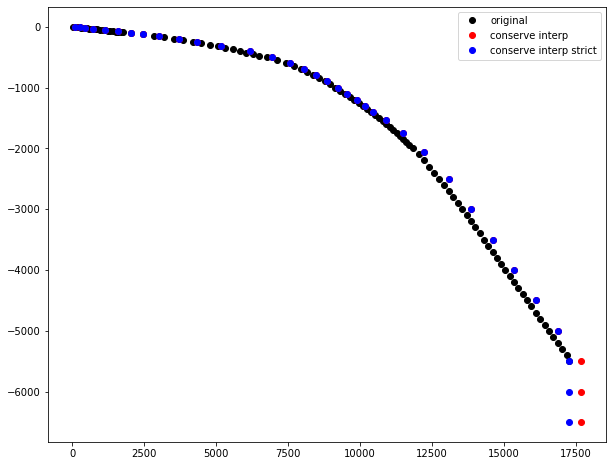

In [19]:
plt.figure(figsize=[10,8])
plt.plot((test_datain*layer_thickness_src).cumsum(), -woa13['depth'], 'ko', label='original')
plt.plot((test_dataout*layer_thickness_tgt).cumsum(), -woa13_remapped['z_l'], 'ro', label='conserve interp')
plt.plot((test_dataout_strict*layer_thickness_tgt).cumsum(), -woa13_remapped_strict['z_l'], 'bo', label='conserve interp strict')
plt.legend()
plt.show()

Now let's find out where the layers intersect and also test a sum:

In [20]:
np.intersect1d(depth_bnds_src, depth_bnds_tgt)

array([   0. ,   62.5,   87.5,  112.5,  137.5, 1625. , 1875. , 2250. ,
       2750. , 3250. , 3750. , 4250. , 4750. , 5250. ])

In [21]:
idx2250_src = (np.abs(depth_bnds_src-2250)).argmin()
idx2250_tgt = (np.abs(depth_bnds_tgt-2250)).argmin()

vertsum_in = (test_datain[:idx2250_src] * layer_thickness_src[:idx2250_src]).sum().values
vertsum_out = (test_dataout[:idx2250_tgt] * layer_thickness_tgt[:idx2250_tgt]).sum().values

assert np.equal(vertsum_in, vertsum_out)

When stopping the integration before the bottom, non-strict conserves the integral.